# Workflow

## Setup

Setup magic autoreload

In [1]:
%load_ext autoreload
%autoreload 2

Setup logging

In [2]:
import logging
from pathlib import Path
from IPython.display import Image, display, Markdown
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# In case of debugging, set the level to logging.DEBUG

Ensure that you have already configured your environment variable following the instructions in the [README](../README.md)

In [3]:
import os
assert os.getenv('LLM_DSL_CONFIG_PATH') is not None, "Please set the LLM_DSL_CONFIG_PATH environment variable to the path of the config file"
assert os.getenv('LLM_DSL_API_PATH') is not None, "Please set the LLM_DSL_CONFIG_PATH environment variable to the path of the config file"

# 1. First glance

2025-02-09 16:31:37,424 - dsl_gen - INFO - Configuration initialized


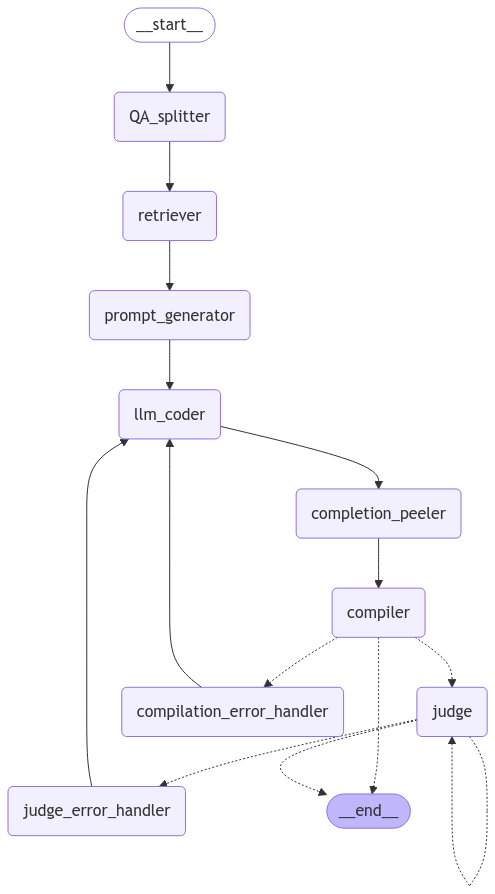

In [4]:
from dsl_gen.core.flows import build_rag_flow
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
flow = build_rag_flow()
flow.get_graph()
display(
    Image(
        flow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

```mermaid
flowchart TD
    __start__(["<p>__start__</p>"]) --> QA_splitter("QA_splitter")
    QA_splitter --> retriever("retriever")
    judge_error_handler --> llm_coder
    compilation_error_handler --> llm_coder
    retriever --> prompt_generator("prompt_generator")
    prompt_generator --> llm_coder("llm_coder")
    llm_coder --> completion_peeler("completion_peeler")
    completion_peeler --> compiler("compiler")

    
    judge("judge") -.-> judge_error_handler("judge_error_handler") & __end__
    compiler -.-> judge & compilation_error_handler("compilation_error_handler")　& __end__
    

     __start__:::first
     __end__:::last
    classDef default fill:#f2f0ff,stroke:#888,stroke-width:1px,line-height:1.2
    classDef first fill-opacity:0,stroke-width:0
    classDef last fill:#bfb6fc,stroke:#888,stroke-width:1px
```

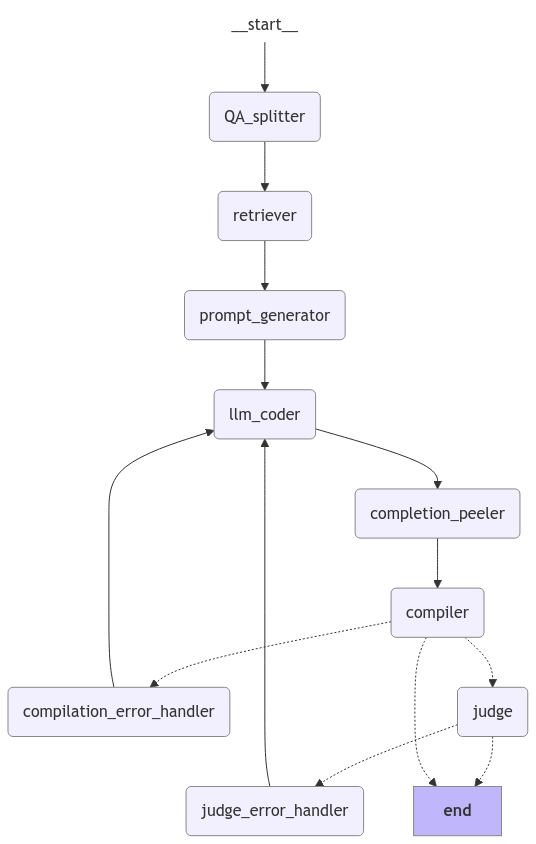

In [5]:
from langchain_core.runnables.graph_mermaid import _render_mermaid_using_api
from PIL import Image
import io

mermaid_graph = """
flowchart TD
    __start__(["<p>__start__</p>"]) --> QA_splitter("QA_splitter")
    QA_splitter --> retriever("retriever")
    judge_error_handler --> llm_coder
    compilation_error_handler --> llm_coder
    retriever --> prompt_generator("prompt_generator")
    prompt_generator --> llm_coder("llm_coder")
    llm_coder --> completion_peeler("completion_peeler")
    completion_peeler --> compiler("compiler")

    
    judge("judge") -.-> judge_error_handler("judge_error_handler") & __end__
    compiler -.-> judge & compilation_error_handler("compilation_error_handler")　& __end__
    

     __start__:::first
     __end__:::last
    classDef default fill:#f2f0ff,stroke:#888,stroke-width:1px,line-height:1.2
    classDef first fill-opacity:0,stroke-width:0
    classDef last fill:#bfb6fc,stroke:#888,stroke-width:1px
"""

Image.open(io.BytesIO(_render_mermaid_using_api(mermaid_graph)))

## How to use

In [5]:
from dsl_gen import CFG

# Set the logging level to DEBUG to see the entire flow
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('dsl_gen')
logger.setLevel(logging.DEBUG)

# Customize the configuration by directly modifying the CFG!
CFG.PRETTY_PRINT = False # Set to True to enable pretty print
CFG.CODER.active_model = 'openai' # 'openai', 'deepseek' or 'ollama'
CFG.JUDGE.active_model = 'openai'


In [6]:
query = 'Define a text literal called greetings with value "Hello" and display greetings on the dashboard as a label.'

result = flow.invoke({"question": query, "question_type": "coding"})

display(Markdown(f"```envision\n{result['completion']}```"))

2025-02-09 16:32:22,188 - dsl_gen - DEBUG - QA Splitter: question provided, eval mode
2025-02-09 16:32:22,190 - dsl_gen - DEBUG - Retrieving docs for query: Define a text literal called greetings with value "Hello" and display greetings on the dashboard as a label.


**Question**
Define a text literal called greetings with value "Hello" and display greetings on the dashboard as a label.


2025-02-09 16:32:25,206 - dsl_gen - INFO - Setting seed: 114514
2025-02-09 16:32:25,207 - dsl_gen - INFO - Loading embedding model into RAM: hf/sentence-transformers/all-mpnet-base-v2
2025-02-09 16:32:30,923 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2025-02-09 16:32:33,876 - dsl_gen - INFO - Loading cached vectorstore from D:/Projects/PSC/LLM-DSL-Gen/vector_db\vectorstore_hf_sentence-transformers_all-mpnet-base-v2
2025-02-09 16:32:33,879 - faiss.loader - INFO - Loading faiss with AVX2 support.
2025-02-09 16:32:33,900 - faiss.loader - INFO - Successfully loaded faiss with AVX2 support.
2025-02-09 16:32:33,907 - faiss - INFO - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.
2025-02-09 16:32:34,132 - dsl_gen - INFO - Retrieved 20 docs
2025-02-09 16:32:34,136 - dsl_gen - DEBUG - Generated prompt: [SystemMessage(content='You are a proficien

**Coder's Completion**
greetings = "Hello"
show label greetings


2025-02-09 16:32:37,665 - dsl_gen - DEBUG - Compilation successful
2025-02-09 16:32:37,667 - dsl_gen - INFO - Code compiled successfully (Attempt 1)
2025-02-09 16:32:39,192 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-09 16:32:39,213 - dsl_gen - INFO - Judgment: 1. **Logical Completeness**  
   - The solution defines a text literal called `greetings` with the value "Hello".
   - It displays the `greetings` on the dashboard as a label.
  
2. **Logical Consistency**  
   - The data flow is straightforward and self-consistent.
   - There are no contradictory conditionals present.

3. **Verifiability**  
   - The critical computation steps are traceable: defining and displaying the `greetings`.
   - Key parameter, which is the value of the `greetings`, is configurable.

**Final Judgment: 1 (Correct)**
2025-02-09 16:32:39,227 - dsl_gen - INFO - Judgment: correct
2025-02-09 16:32:39,237 - dsl_gen - INFO - Answer passed quality check

```envision
greetings = "Hello"
show label greetings```

Or you can simply pass a string as the question for the workflow.

In [1]:
challenge_path = Path(CFG.PATH_CFG.CHALLENGES_PATH) / "c000.json"

result = flow.invoke({"challenge_path": str(challenge_path)}) 

display(Markdown(f"```envision\n{result['completion']}```"))

NameError: name 'Path' is not defined

# 2. Visualize RAGState

In [2]:
from dsl_gen.core import build_rag_flow, visualize_state

flow = build_rag_flow()

query = 'Define a text literal called greetings with value "Hello" and display greetings on the dashboard as a label.'

result = flow.invoke({"question": query, "question_type": "coding"})

visualize_state(result)

2025-02-09 18:12:46,586 - INFO - Configuration initialized


**Question**
Define a text literal called greetings with value "Hello" and display greetings on the dashboard as a label.


2025-02-09 18:12:51,751 - INFO - Setting seed: 114514
2025-02-09 18:12:51,752 - INFO - Loading embedding model into RAM: hf/sentence-transformers/all-mpnet-base-v2
2025-02-09 18:12:56,156 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2025-02-09 18:12:58,195 - INFO - Loading cached vectorstore from D:/Projects/PSC/LLM-DSL-Gen/vector_db\vectorstore_hf_sentence-transformers_all-mpnet-base-v2
2025-02-09 18:12:58,198 - INFO - Loading faiss with AVX2 support.
2025-02-09 18:12:58,215 - INFO - Successfully loaded faiss with AVX2 support.
2025-02-09 18:12:58,221 - INFO - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.
2025-02-09 18:12:58,457 - INFO - Retrieved 20 docs
2025-02-09 18:12:58,860 - INFO - Model loaded: gpt-3.5-turbo, base_url: https://api.openai.com/v1
2025-02-09 18:12:59,650 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


**Coder's Completion**
greetings = "Hello"
show label greetings


2025-02-09 18:13:00,785 - INFO - Code compiled successfully (Attempt 1)
2025-02-09 18:13:02,415 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-09 18:13:02,420 - INFO - Judgment: 1. **Logical Completeness**  
   - The solution defines a text literal called `greetings` with the correct value "Hello".
   - It also displays `greetings` on the dashboard as a label.

2. **Logical Consistency**  
   - There are no contradictory conditionals or conflicting statements present in the solution.

3. **Verifiability**  
   - The critical computation steps are easily traceable: defining `greetings` and displaying it as a label.
   - The key parameter (`greetings` text value) is configurable.

Based on the evaluation, the solution is logically complete, consistent, and verifiable.  
**Final Judgment: 1**  
The solution is correct.
2025-02-09 18:13:02,421 - INFO - Judgment: correct
2025-02-09 18:13:02,422 - INFO - Answer passed quality check


**Question:** `Define a text literal called greetings with value "Hello" and display greetings on the dashboard as a label.`

**Question Type:** `coding`

**Retrieved Documents:**

- `## Hello World program  
Every script must display at least _one_ dashboard _tile_. The following script illustrates how to generate a dashboard that contains a single tile displaying _Hello World!_. ...`

- `## Your first script  
Every script must display at least _one_ dashboard _tile_. The following script illustrates how to generate a dashboard that contains a single tile displaying _Hello World!_.  
...`

- `+++
title = "Dashboards"
description = ""
weight = 11
alwaysopen = false
+++  
Rewrite pending.  
* See also [(Legacy) Designing dashboards](/legacy/envision-user-guide/designing-dashboards/)
* See al...`

- `## Displaying things on Dashboard using tile  
The tile is the fundamental display block in Envision. Envision supports many types of tiles such as barcharts, linecharts, tables, etc. A script can con...`

- `The script below is strictly equivalent to the one above, be aware however not to confuse the first StyleCode snippet prefixed with a `@` (hence targeting the dashboard), with its counterpart without ...`

- `## Interactive use of form values
<!-- TODO: screenshot of the editable form missing -->
Form values are read with a `read form` statement, and they can modified through direct interaction with a dash...`

- `+++
title = "Slicing dashboards"
description = "Slicing is a mechanism to compute many variants of the same dashboard and let end-users interact with the resulting 'sliced dashboard' through a search-...`

- `## How to write comments  
Comments are introduced with the double-slash `//`. They can be put at the beginning of a line, or to the right of the line.  
```envision
// This is a full line comment.
gr...`

- `greeting = with
  x = "Hello, world!"
  return x

show label greeting a1c1 // Displays 'Hello, world!'
show label x a2c2 // Displays 'Hello?'
```  
It would be possible to explicit all the tables invo...`

- `

show label greeting
```  
Which, unsurprisingly, displays `Hello World!`.  
The first line of the above script contains the declaration of the `hello()` function. This declaration starts with the ke...`

- `

show form "My form values" a1a4 with b, d, n, t
```  
The resulting dashboard is editable: the form values can be modified interactively. When `Start run` button is clicked, the current form values,...`

- `## Structured documentation  
Variables in Envision can be documented with with a triple-slash `///` comment. In order to obtain the structured documentation behavior, the `///` has to be put at the b...`

- `## Tiles  
Running an Envision script produces a dashboard, and the dashboard is composed of tiles. Envision supports multiple tiles.  
```envision
table T = extend.range(10)
T.X = random.poisson(5 in...`

- `## Overview  
Let’s create a module named `sample/my-module` from the `Projects` view by clicking the dropdown next to `Create Envision script`. Through the code editor, let’s enter the follow code fo...`

- `

show label greeting
```  
The keyword `with` is used to introduce a _block_ that is defined by its higher indentation level (just like in Python). The variable `x` is restricted to the block introdu...`

- `## Usage guidelines  
As far as modules are concerned, we suggest:  
* Keep module paths plain. Avoid whitespaces, capitalization and non-alphanumeric characters.
* Use folders to isolate modules from...`

- `c = strlen(greeting)// Hover with your mouse on 'greeting', you get the message below.
```  
The Markdown syntax is used for the structured documentation. In the above example, when hovering the varia...`

- `## Fix the position when displaying a tile on Dashboard  
Tiles can be positioned within a dashboard by leveraging a grid layout similar to the one used in most spreadsheets, with columns identified b...`

- `## insert a value into string  
Envision supports what is commonly referred to as _text interpolation_ for its `text` values.  
```envision
x = 42
message = "My number is \{x}." // yields "My number i...`

- `

show linechart "Weekly Orders" a1c2 {seriesType: "line"} with
  Week.Quantity
```  
The `linechart` tile has a native affinity to the three calendar tables `Day`, `Week` and `Month`. This tile canno...`

**Raw Completion:** `content='```envision\ngreetings = "Hello"\nshow label greetings\n```' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 5319, 'total_tokens': 5335, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-7c9ca930-7e85-4fcf-beb4-95aa335d7271-0' usage_metadata={'input_tokens': 5319, 'output_tokens': 16, 'total_tokens': 5335, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}`

**Final Completion:** `greetings = "Hello"
show label greetings`

**Compilation Result:** `True`

**Judgment:** `correct`

**Judge Output:** `1. **Logical Completeness**  
   - The solution defines a text literal called `greetings` with the correct value "Hello".
   - It also displays `greetings` on the dashboard as a label.

2. **Logical Consistency**  
   - There are no contradictory conditionals or conflicting statements present in the solution.

3. **Verifiability**  
   - The critical computation steps are easily traceable: defining `greetings` and displaying it as a label.
   - The key parameter (`greetings` text value) is configurable.

Based on the evaluation, the solution is logically complete, consistent, and verifiable.  
**Final Judgment: 1**  
The solution is correct.`

**Messages:**

- `You are a proficient coder in a Domain Specific Language called Envision. Your task is to generate response to the given challenge. Some challenges will ask you to generate Envision code,others will ask you to explain given code or answer questions related to the Envision language. Do not output any intermediate thinking or explanation, only give the final answer.`

- `Relevant Context:
Document 1 (from D:/Projects/PSC/LLM-DSL-Gen/docs\_index.md):
## Hello World program  
Every script must display at least _one_ dashboard _tile_. The following script illustrates how to generate a dashboard that contains a single tile displaying _Hello World!_.  
```envision
greeting = "Hello World!"
show label greeting
```  
All the statements that start with the keyword `show` indicate that a _tile_ will be displayed. Tiles are the display mechanism provided by Envision. All the tiles present in a script are consolidated in a _dashboard_.  
The value `"Hello World!"` is called a **text literal**, a value that appears verbatim in the code. The operator `=` is the **assignment operator**.

Document 2 (from D:/Projects/PSC/LLM-DSL-Gen/docs\envision-brief.md):
## Your first script  
Every script must display at least _one_ dashboard _tile_. The following script illustrates how to generate a dashboard that contains a single tile displaying _Hello World!_.  
```envision
greeting = "Hello World!"
show label greeting
```  
All the statements that start with the keyword `show` indicate that a _tile_ will be displayed. Tiles are the display mechanism provided by Envision. All the tiles present in a script are consolidated in a _dashboard_.  
Attention that if we use "show label", the format should be
```envision
show label labelContent
```
without writing "with" and the label does not have a title. this is different from show table :
```envision
show table "ChartName" with tableContent
```  
The value `"Hello World!"` is called a **text literal**, a value that appears verbatim in the code. The operator `=` is the **assignment operator**.

Document 3 (from D:/Projects/PSC/LLM-DSL-Gen/docs\dashboard_index.md):
+++
title = "Dashboards"
description = ""
weight = 11
alwaysopen = false
+++  
Rewrite pending.  
* See also [(Legacy) Designing dashboards](/legacy/envision-user-guide/designing-dashboards/)
* See also [(Legacy) Styling dashboards](/legacy/envision-user-guide/styling-dashboards/)
* See also [(Legacy) Beautifying dashboards](/legacy/envision-user-guide/beautifying-dashboards/)

Document 4 (from D:/Projects/PSC/LLM-DSL-Gen/docs\_index.md):
## Displaying things on Dashboard using tile  
The tile is the fundamental display block in Envision. Envision supports many types of tiles such as barcharts, linecharts, tables, etc. A script can contain many tiles that will all be rendered in the same single-page dashboard. Nearly all tiles receive a _table_ as input, introduced by the keyword `with` that renders this table in one form or another. For example, the following script displays two tiles:  
```envision
show scalar "First title" with "Hello"
show scalar "Second title" with "World!"
```  
The syntax to display a tile always includes a short series of elements:  
1. the `show` keyword, which indicates that a tile will be displayed. A tile is pure side-effect: it does not return any value, nor does it have any effect on any other tile.
2. the tile type keyword (`scalar` in the example above), which specifies how the data passed as an input will be rendered. There are about a dozen types of tiles.
3. the tile title which should be a scalar text value, but not necessarily a text literal.
4. the `with` keyword, required for all tiles except `label` one, which introduces the list of vectors to be used as the input for the tile. Here we are using the _inline_ form of `with`, the `block` form is introduced below.  
Complex tables can be used as inputs for tiles, as illustrated by:  
```envision
table Products = with
  [| as Product |] // column's names
  [| "shirt" |]
  [| "pants" |]
  [| "socks" |]

Document 5 (from D:/Projects/PSC/LLM-DSL-Gen/docs\_index.md):
The script below is strictly equivalent to the one above, be aware however not to confuse the first StyleCode snippet prefixed with a `@` (hence targeting the dashboard), with its counterpart without the `@` where the snippet targets the `table` tile that immediately follows.

```envision
@{ textColor: blue } // '@' selects the dashboard itself
show table "My table" b1c2 with
  "Hello" as "First column" { textColor: red }
  "World!" as "Second column"
```

Document 6 (from D:/Projects/PSC/LLM-DSL-Gen/docs\forms.md):
## Interactive use of form values
<!-- TODO: screenshot of the editable form missing -->
Form values are read with a `read form` statement, and they can modified through direct interaction with a dashboard with the `show form` statement.  
```envision
read form with
  b : boolean
  d : date
  n : number
  t : text

Document 7 (from D:/Projects/PSC/LLM-DSL-Gen/docs\dashboard_slicing.md):
+++
title = "Slicing dashboards"
description = "Slicing is a mechanism to compute many variants of the same dashboard and let end-users interact with the resulting 'sliced dashboard' through a search-like navigation. For example, through slicing, it is possible to create a product inspector which consolidates - for every product - all the KPIs and linecharts of interest."
weight = 6
+++  
Slicing is a mechanism to compute many variants of the same dashboard and let end-users interact with the resulting _sliced dashboard_ through a search-like navigation. For example, through slicing, it is possible to create a product inspector which consolidates - for every product - all the KPIs and linecharts of interest.  
The following script provides a simplistic variant of such a dashboard:  
```envision
table Products[pid] = with
  [| as Product, as Color, as Price |]
  [| "pants",   "blue",    25       |]
  [| "shirt",   "white",   15       |]
  [| "socks",   "green",   5        |]

Document 8 (from D:/Projects/PSC/LLM-DSL-Gen/docs\_index.md):
## How to write comments  
Comments are introduced with the double-slash `//`. They can be put at the beginning of a line, or to the right of the line.  
```envision
// This is a full line comment.
greeting = "Hello, world!" // This is a trailing comment.
show label greeting
```  
Comments can also be introduced with the alternative syntax `/* */` which supports inlining.  
```envision
greeting = "Hello, world!"
show label /* inline comment */ greeting /* this
                                            works
                                            too */
```

Document 9 (from D:/Projects/PSC/LLM-DSL-Gen/docs\_index.md):
greeting = with
  x = "Hello, world!"
  return x

show label greeting a1c1 // Displays 'Hello, world!'
show label x a2c2 // Displays 'Hello?'
```  
It would be possible to explicit all the tables involved with the following equivalent script:  
```envision
Scalar.greeting = with
  Scalar.x = "Hello World!"
  return Scalar.x

show label Scalar.greeting
```

Document 10 (from D:/Projects/PSC/LLM-DSL-Gen/docs\functions.md):


show label greeting
```  
Which, unsurprisingly, displays `Hello World!`.  
The first line of the above script contains the declaration of the `hello()` function. This declaration starts with the keyword `def` and ends with the keyword `with`. The keyword `pure` indicates the type of the function. The argument is named `a`, and its data type is specified through the colon (`:`) symbol. As usual, `with` opens a new block, and thus the next line comes with an extra level of indentation. Then, the second and last line of the function definition uses the keyword `return` to specify the value returned by the function. The function `hello()` is then called to define the scalar value `greeting`, and this value is finally displayed through a `label` tile at the last line of the script.  
All the function’s declarations require the sequence of keywords `def`, `with` and `return`. Also, the last statement of the function block must be a `return` statement. The type of the function can be either `pure` or `process` - we will be getting back to the latter in the following. Finally, a function must be declared before being called. The call syntax is identical to the one used to call functions from the standard library.  
Functions (processes included) come with table-free (i.e. scalar) arguments and return a tuple of table-free values as well. The compiler does not allow the use of a table prefix within the function declaration line or within the function body. This design differs from regular Envision expressions that always have an affinity to a specific table, even if it’s only the `Scalar` table. While the terminology can be a bit confusing, when we say that functions are _scalar_, we indicate they operate over values instead of vectors.  
The scalar nature of functions offers the possibility to automatically vectorize them, i.e. let them take a vector as input and return a vector as output as illustrated by:  
```envision
table Audience = with
  [|as Folks |]
  [| "Ladies" |]
  [| "Gentlemen" |]
  [| "Mr. the President" |]

Document 11 (from D:/Projects/PSC/LLM-DSL-Gen/docs\forms.md):


show form "My form values" a1a4 with b, d, n, t
```  
The resulting dashboard is editable: the form values can be modified interactively. When `Start run` button is clicked, the current form values, as displayed on the dashboard, are persisted. Those newer values becomes immediately accessible to the new run through the `read form` block.  
When a new form value is introduced in a script, its value matches the default value for the datatype, e.g. 0 for `number`.  
Form values are scalars. Those values can be accessed with the special prefix `form`, however, this prefix isn't a table, merely a namespace for form values.  
```envision
read form with
  n : number

Document 12 (from D:/Projects/PSC/LLM-DSL-Gen/docs\_index.md):
## Structured documentation  
Variables in Envision can be documented with with a triple-slash `///` comment. In order to obtain the structured documentation behavior, the `///` has to be put at the beginning of the line, and just before the documented variable.  
```envision
/// This is a **bold** message,
/// and multiline works too!
greeting = "Hello, world!"

Document 13 (from D:/Projects/PSC/LLM-DSL-Gen/docs\envision-brief.md):
## Tiles  
Running an Envision script produces a dashboard, and the dashboard is composed of tiles. Envision supports multiple tiles.  
```envision
table T = extend.range(10)
T.X = random.poisson(5 into T) // 'into' broadcasts scalar '5' into table 'T'
T.G = "G\{T.N}"
 
// Horizontal bars
show barchart "My Groups" a1b8 with
  sum(T.X) // must be a number
  max(T.X) //
  group by T.G // required for 'barchart'
```  
```envision
table T = extend.range(1000)
T.X = random.poisson(5 into T)
 
 // Vertical bars
show histogram "My histogram" a1f4 with T.X
```  
```envision
// Day, Week and Month, the special calendar tables are implicitely created by 'span'
// (other way: use 'read' with '[date]'  as secondary dimension)
keep span date = [date(2021, 5, 1) .. date(2021, 7, 30)]
 
Day.X = random.poisson(5 into Day)
Week.X = sum(Day.X)
Month.X = sum(Day.X)
 
show linechart "Daily (2 lines)" a1b4 with
  Day.X
  Day.X + 3 as "X shifted" { color: "red" } // web colors
show linechart "Weekly" a5b6 with Week.X
show linechart "Monthly" a7b8 with Month.X
```  
```envision
keep span date = [date(2021, 5, 3) .. date(2021, 7,6)]
 
def pure isTuesday(d : date) with // pure function
  return d == monday(d) + 1 // body of the function
def pure isWeekend(d: date) with
  return d >= monday(d) + 5
 
// Flat replenishments of 120 units on Tuesdays.
Day.Restock = if not(isTuesday(date)) then 0 else 120 // ternary
 
// Simulating a random demand that increases on the weekend.
Day.Demand = random.ranvar(poisson(15 into Day)) // 'into' broadcasts scalar into 'Day' table
Day.Demand = if isWeekend(date) then floor(Day.Demand * 1.2 + 5) else Day.Demand
 
// Positive cumulative sum to prevent negative stock.
def process positiveCumsum(n : number) with
  keep sum = 0 // 'keep' defines the state of the process, 'sum' is persisted across calls
  sum = max(0, sum + n)
  return sum
 
Day.Stock = positiveCumsum(Day.Restock - Day.Demand) scan date
Day.Sales = Day.Stock[-1] - Day.Stock + Day.Restock // [-1] lags the table (only for calendar tables)
 
show linechart "Stock level simulator" a1h6 { legendPosition: left ; vaxis { left { axisMax: 500 } } } with
  Day.Restock as "Daily restock" { seriesType: bar ; unit: " stock" ; color:#7e7 }
  Day.Stock as "End of day stock" { seriesType: bar ; seriesOpacity: 0.6; unit: " stock" ; color:#666 }
  Day.Sales as "Daily sales" { seriesType: line ; color: gray ; seriesStack:"stackSales" ; unit: " sold" }
  Day.Demand - Day.Sales as "Unsatisfied demand" { seriesType: area ; seriesOpacity: 0.6 ; seriesStack:"stackSales" ; unit:" sold"; color:#fa0 }
  if isWeekend(date) then 1 else 0 { seriesType: background ; seriesLegend: hidden ; seriesOpacity: 0.25 ; color: #f99 }
  group by date
```  
```envision
// Markdown is both a data type and a tile type.

Document 14 (from D:/Projects/PSC/LLM-DSL-Gen/docs\modules.md):
## Overview  
Let’s create a module named `sample/my-module` from the `Projects` view by clicking the dropdown next to `Create Envision script`. Through the code editor, let’s enter the follow code for the module itself, and click `Save`:  
```envision
// Module named 'sample/my-module'
export const myHello = "Hello"
export const myWorld =  "World!"
```  
The above module exports two scalar text constants. As the name suggests, the keyword `export` identifies the values found within the module and makes them accessible outside the external scripts.  
<!--  TODO: screenshot of the module code editor -->
Unlike a script, a module cannot be executed and consequently does not produce dashboards. While editing the code of the module, the code editor does not offer the button `Start Run` as part of the right sidebar, as is usually the case when editing scripts.  
A script can then be introduced:  
```envision
import "sample/my-module" as M with
  myHello
  myWorld

Document 15 (from D:/Projects/PSC/LLM-DSL-Gen/docs\_index.md):


show label greeting
```  
The keyword `with` is used to introduce a _block_ that is defined by its higher indentation level (just like in Python). The variable `x` is restricted to the block introduced by the `with` keyword. This block ends with the `return` statement. Attempting to use either `x` past the `return` statement would yield a compiler error.  
A block introduced by `with` and ending with a `return` statement is referred to as a _return block_ in Envision and it is intended as a pure scoping mechanism.  
In addition, if `x` has been assigned before the `with` block, its previous value is restored upon leaving the block, as illustrated by:  
```envision
x = "Hello?"

Document 16 (from D:/Projects/PSC/LLM-DSL-Gen/docs\modules.md):
## Usage guidelines  
As far as modules are concerned, we suggest:  
* Keep module paths plain. Avoid whitespaces, capitalization and non-alphanumeric characters.
* Use folders to isolate modules from scripts. Keep modules together.
* Isolate StyleCode elements in modules to maintain a visual unity over many dashboards.
* Isolate constants such as default lead times, default margins, … in modules.
* Take advantage of the `///` structured documentation for exported elements. Don't hesitate to use long insightful comments spanning over multiple lines.
* Polish more extensively, .e.g. more documentation efforts, frequently reimported modules than stand-alone scripts.

Document 17 (from D:/Projects/PSC/LLM-DSL-Gen/docs\_index.md):
c = strlen(greeting)// Hover with your mouse on 'greeting', you get the message below.
```  
The Markdown syntax is used for the structured documentation. In the above example, when hovering the variable `greeting`, the word `bold` appears in bold due to the use of the `** .. **` delimiters. An structured documentation block can include multiple lines.  
Like comments, the structured documentation has no impact on the logic of the script.

Document 18 (from D:/Projects/PSC/LLM-DSL-Gen/docs\_index.md):
## Fix the position when displaying a tile on Dashboard  
Tiles can be positioned within a dashboard by leveraging a grid layout similar to the one used in most spreadsheets, with columns identified by letters and lines identified by numbers. Tiles are positioned through code, however, Lokad also features a visual editor precisely intended to place and style tiles in a more convenient way than manual adjustments of constants in code. The following script illustrates the grid layout of Envision:  
<!-- TODO: #6064 It would be clearer here to use named colors instead, however it seems we have a bug that prevents this. See https://lokad.atlassian.net/browse/LK-6064 (released) -->  
```envision
show label "A" a1 { backgroundColor: #8aa }
show label "B" a2 { backgroundColor: #aaa }
show label "C" b1c2 { backgroundColor: #caa }
```  
![Image](/images/tile-editor-settings.png)  
In the above script, the values `a1`, `a2`  and `b1c2` are encoding the placement of the tile. The value `a1` indicates that the tile starts on the column `a` and line `1`, and by default, the height and width of the tile are equal to 1. The value `b1c2` indicates that the tile starts on the column `b` and line `1` while it ends on the column `c` and line `2`. The background color is defined - more on this in the next section - to help visualize where each tile starts and ends within the dashboard depending on its coordinates.  
<!-- TODO: #6065 The display does not look too good at this point of time for this specific example.
See https://lokad.atlassian.net/browse/LK-6065 (closed as duplicate) -->  
The syntax is unchanged when more complex tiles that involve input vectors are used:  
```envision
myText = "Hello world!"
show scalar "A" a1 { backgroundColor: #8aa } with myText
show scalar "B" a2 { backgroundColor: #aaa } with myText
show scalar "C" b1c2 { backgroundColor: #caa } with myText
```  
![Image](/images/interface-tile-editor-settings.png)
<!-- 2020-10-02 Gierling: screenshot showing the example script in the tile editor -->  
The position of the tile is an optional argument that immediately follows the title of the tile. However, in practice, it is strongly recommended to explicitly set the position of every tile, as the default behavior rarely yields nice looking dashboards: by default, Envision seeks from the lowest line to the first cell available up to the 8th column (i.e. `h` column) before going for the next line.  
In the following, most of our script examples omit the position argument for the sake of concision, however, this choice should not be interpreted as a preference toward automatic dashboard layouts. The _intended_ path in Envision is to carefully craft dashboards with well-placed tiles. In order to support this undertaking, Lokad supports a **tile editor**, which is distinct from the _code editor_. Both editors will be reviewed in greater detail in later sections.  
Capitalization of the positions is ignored, thus `b1c2` is identical to `B1C2`. The maximum number of columns is 26, i.e. `z` is the largest acceptable column identifier, while the maximum number of lines is 999. These values are (almost) absurdly large. As a rule of thumb, dashboards that exceed the column `h` or exceed the line 100 tend to be largely unreadable.

Document 19 (from D:/Projects/PSC/LLM-DSL-Gen/docs\_index.md):
## insert a value into string  
Envision supports what is commonly referred to as _text interpolation_ for its `text` values.  
```envision
x = 42
message = "My number is \{x}." // yields "My number is 42"
```  
The syntax requires the variable to be included with a block `\{..}` (don't forget the backslach `\`).  
Envision does not support interpolating expressions, only variables.

Document 20 (from D:/Projects/PSC/LLM-DSL-Gen/docs\calendar.md):


show linechart "Weekly Orders" a1c2 {seriesType: "line"} with
  Week.Quantity
```  
The `linechart` tile has a native affinity to the three calendar tables `Day`, `Week` and `Month`. This tile cannot display data that originates from other tables. We will be revisiting below in greater detail the line charts’ behavior.  
Meanwhile, let’s do a brief recap of the calendar tables:  
| Table | Dimension | Data type |
|-------|-----------|-----------|
| Day   | date      | date      |
| Week  | week      | week      |
| Month | month     | month     |  
The same word, e.g. `month`, refers to distinct constructs in the Envision language.  
The calendar tables cannot be defined with the usual `table T = with ..` syntax. Indeed, this would lead to situations where `Day` is defined with a non-contiguous list of `date` values causing strange behavior for the programmer. Thus, those calendar tables can only be defined either through a `read` block featuring `expert [date]` (as seen above), with with an unfiltering statement (as detailed below).  
At this point, there are still a few Envision behaviors that we haven’t covered in regards to the examples introduced in this section. These behaviors will be gradually clarified in the subsections that follow.

Based on the above context and your knowledge, respond to:`

- `Define a text literal called greetings with value "Hello" and display greetings on the dashboard as a label.`

# 3. Components

## VectorDB

Uncomment the following line to build vectorstore manually.

In [3]:
# from dsl_gen.core.vector_store import _build_vectorstore
# store = _build_vectorstore()

### Visualize a question

Before building vectorstore, we can visualize a question to understand the data.

In [ ]:
from IPython.display import Markdown


display(Markdown(query))
answer = '```envision\ngreetings = "Hello" // define the text literal\nshow label greetings // show the text literal as a label. There should be no \'with\' !\n```'
display(Markdown(answer))

## Build vectorstore

In [ ]:
from dsl_gen.core.vector_store import get_vectorstore
from dsl_gen.config import CFG

# It is normal that you see INFO - Failed to load GPU Faiss
# Since we are using CPU Faiss
vectorstore = get_vectorstore()

<span style="color:green;"><b>It is normal that you see the message</b></span> `Failed to load GPU Faiss` <span style="color:green;"><b>since we are using</b></span> `Faiss-CPU`.

Let's see how to retrieve docs by their indices

In [ ]:
from IPython.display import Markdown
doc_ids = list(vectorstore.index_to_docstore_id.values())[:5]
for doc_id in doc_ids:
    document = vectorstore.docstore.search(doc_id)
    display(Markdown(document.page_content))

In [ ]:
doc_ids = list(vectorstore.index_to_docstore_id.values())[50:53]

display(Markdown('### Displaying documents 50, 51, 52'))

for doc_id in doc_ids:
    document = vectorstore.docstore.search(doc_id)
    
    display(Markdown(document.page_content))

## Similarity search

In [9]:
vectorstore = get_vectorstore()

In [ ]:
query="Define a text literal called greetings with value \"Hello\" and display greetings on the dashboard as a label."
documents = vectorstore.similarity_search(k = 3, query=query)
document

In [ ]:
for idx, doc in enumerate(documents):
    display(Markdown(f"### Document {idx} \n {doc.page_content}"))
display(Markdown('---'))

## Try queries with a few questions

In [ ]:
from dsl_gen.core.vector_store import get_vectorstore
from dsl_gen.config import CFG
from pathlib import Path
import json

vectorstore = get_vectorstore()

file_path = Path(CFG.PATH_CFG.CHALLENGES_PATH) / "c001.json"

with open(file_path, 'r') as f:
    data = json.load(f)

question = data['question']

print(question)

In [ ]:
documents = vectorstore.similarity_search(k = 20, query=question)
document

In [ ]:
for idx, doc in enumerate(documents):
    print(f"Document {idx}")
    print(doc.page_content)
    print('\n')

---

# Appendix: VectorStore

Below is a detailed explanation of VectorStore content display and similarity search filters:

---

## How to View Chunk Content in VectorStore

### Method 1: Directly Accessing the Underlying Storage (Using FAISS as an Example)

```python
# Assuming an initialized vectorstore object

from langchain_community.vectorstores import FAISS

def show_all_chunks(vectorstore: FAISS) -> list:
    """Displays all stored chunks and their metadata"""
    chunks = []
    # Iterate through all document IDs
    for doc_id in vectorstore.index_to_docstore_id.values():
        document = vectorstore.docstore.search(doc_id)
        chunks.append({
            "id": doc_id,
            "content": document.page_content,
            "metadata": document.metadata
        })
    return chunks

# Example usage
for chunk in show_all_chunks(vectorstore):
    print(f"[ID: {chunk['id']}]")
    print(f"Metadata: {chunk['metadata']}")
    print(f"Content: {chunk['content'][:50]}...\n")

# Sample Output:
# [ID: 89a3b2f1]
# Metadata: {'source': 'manual.pdf', 'page': 23}
# Content: Envision language supports time series analysis using window functions...
```

### Method 2: Retrieve All Chunks via Search (Temporary Approach)
```python
# Retrieve all documents by searching an empty string (Use with caution)
all_docs = vectorstore.similarity_search(query="", k=1000)  # Set k to a sufficiently large number
for i, doc in enumerate(all_docs):
    print(f"Chunk {i+1}: {doc.page_content[:80]}...")
```

---

## **Understanding the `similarity_search` Filter Parameter**

### Purpose
- **Metadata Filtering**: Restrict searches to documents that meet specific criteria.
- **Performance Optimization**: Reduce the number of candidate documents that need to be compared.
- **Business Adaptability**: Dynamically adjust the search scope based on use cases.

### Filtering Syntax Examples
```python
# Basic filtering (Equality)
vectorstore.similarity_search(
    "Time Series Forecasting",
    filter={"source": "finance_docs"},  # Search only financial documents
    k=3
)

# Comparison Operators
vectorstore.similarity_search(
    "Data Cleaning",
    filter={
        "page": {"$gte": 50},          # Page number >= 50
        "version": {"$ne": "draft"}    # Exclude draft versions
    }
)

# Multiple Conditions
vectorstore.similarity_search(
    "Machine Learning",
    filter={
        "$and": [
            {"category": "AI"},
            {"security_level": {"$lte": 2}}
        ]
    }
)

# Array Containment
vectorstore.similarity_search(
    "Distributed Computing", 
    filter={
        "tags": {"$in": ["spark", "hadoop"]}  # Includes any specified tags
    }
)
```

### Supported Operators
| Operator | Description             | Example                          |
|----------|-------------------------|----------------------------------|
| `$eq`    | Equals (default)         | `{"author": "John"}`            |
| `$ne`    | Not equals               | `{"status": {"$ne": "draft"}}`  |
| `$gt`    | Greater than             | `{"views": {"$gt": 1000}}`      |
| `$gte`   | Greater than or equal to | `{"year": {"$gte": 2020}}`      |
| `$lt`    | Less than                | `{"priority": {"$lt": 5}}`      |
| `$lte`   | Less than or equal to    | `{"rating": {"$lte": 4.5}}`     |
| `$in`    | Contained in array       | `{"tags": {"$in": ["AI"]}}`     |
| `$nin`   | Not contained in array   | `{"lang": {"$nin": ["zh"]}}`    |
| `$and`   | Logical AND              | See combined example above      |
| `$or`    | Logical OR               | `{"$or": [cond1, cond2]}`       |

---

## **Best Practices and Practical Advice**

### 1. **Metadata Design Tips**
- Inject structured metadata when splitting documents.
```python
from langchain.docstore.document import Document

Document(
    page_content=chunk_text,
    metadata={
        "source": "user_manual_v3.pdf",
        "section": "API Reference",
        "last_updated": "2024-03-15"
    }
)
```

### 2. **Efficient Filtering Strategies**
```python
# Predefined common filters
FILTERS = {
    "technical_docs": {"doc_type": "technical"},
    "recent_updates": {"last_updated": {"$gte": "2024-01-01"}},
    "high_priority": {"priority": {"$gte": 8}}
}

# Dynamically build filters
def build_filter(include_filters: list[str]):
    return {"$and": [FILTERS[f] for f in include_filters]}
```

### 3. **Debugging and Metadata Analysis**
```python
# Display metadata field distributions
from collections import defaultdict

def analyze_metadata(vectorstore):
    field_stats = defaultdict(set)
    for doc_id in vectorstore.index_to_docstore_id.values():
        doc = vectorstore.docstore.search(doc_id)
        for k, v in doc.metadata.items():
            field_stats[k].add(str(v))  # Convert to string to avoid type issues
  
    for field, values in field_stats.items():
        print(f"Field '{field}':")
        print(f"  Unique values ({len(values)}): {', '.join(list(values)[:3])}...")

# Sample Output:
# Field 'source': 
#   Unique values (4): manual_v2.pdf, blog_post.md, api_spec.json...
```

By effectively utilizing metadata filtering and content inspection methods, you can significantly enhance the **controllability** and **interpretability** of a Retrieval-Augmented Generation (RAG) system.